In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amangarg08/apple-retail-sales-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'apple-retail-sales-dataset' dataset.
Path to dataset files: /kaggle/input/apple-retail-sales-dataset


In [2]:
import os

files = os.listdir(path)
print("Daftar file:", files)

Daftar file: ['products.csv', 'sales.csv', 'warranty.csv', 'stores.csv', 'category.csv']


In [3]:
import pandas as pd

# Membaca semua file ke dalam dictionary dataframe
dfs = {}
for file in ['category.csv', 'warranty.csv', 'products.csv', 'stores.csv', 'sales.csv']:
    file_path = os.path.join(path, file)
    dfs[file.split('.')[0]] = pd.read_csv(file_path)

dfs['sales'].head()

,sale_id,sale_date,store_id,product_id,quantity
0,YG-8782,16-06-2023,ST-10,P-38,10
1,QX-999001,13-04-2022,ST-63,P-48,10
2,JG-46890,05-07-2021,ST-26,P-79,5
3,XJ-1731,20-07-2022,ST-15,P-24,9
4,FG-95080,18-03-2022,ST-35,P-69,7


## Cleaning Data

In [4]:
import pandas as pd
import numpy as np

# 1. Standardize Column Names (Avoid Case-Sensitivity Issues)
# We want to make sure 'product_id' vs 'Product_ID' doesn't break our code
for name in dfs:
    dfs[name].columns = [col.strip() for col in dfs[name].columns]

# 2. Date Standardization
# If dates are strings, they can't be filtered by year easily
print("Standardizing dates...")
if 'sales' in dfs:
    dfs['sales']['sale_date'] = pd.to_datetime(dfs['sales']['sale_date'], errors='coerce')
if 'warranty' in dfs:
    dfs['warranty']['claim_date'] = pd.to_datetime(dfs['warranty']['claim_date'], errors='coerce')

# 3. Handling Missing Values
# For retail data, we usually drop rows where critical IDs are missing
print("Handling missing values...")
dfs['sales'] = dfs['sales'].dropna(subset=['sale_id', 'product_id', 'store_id'])

# 4. Removing Duplicates
# Important! Duplicate sales rows will inflate your revenue figures
for name in dfs:
    initial_count = len(dfs[name])
    dfs[name] = dfs[name].drop_duplicates()
    final_count = len(dfs[name])
    if initial_count > final_count:
        print(f"Removed {initial_count - final_count} duplicates from {name}")

# 5. Numerical Validation
# Ensuring Price and Quantity are positive numbers
if 'products' in dfs:
    dfs['products'] = dfs['products'][dfs['products']['Price'] >= 0]
if 'sales' in dfs:
    dfs['sales'] = dfs['sales'][dfs['sales']['quantity'] > 0]

print("✅ Data cleaning complete. Ready for analysis!")

Standardizing dates...


/tmp/ipython-input-2130787157.py:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dfs['sales']['sale_date'] = pd.to_datetime(dfs['sales']['sale_date'], errors='coerce')


Handling missing values...
✅ Data cleaning complete. Ready for analysis!


##Load Data

In [5]:
sales = dfs['sales']
stores = dfs['stores']
products = dfs['products']
warranty = dfs['warranty']
category = dfs['category']

In [6]:
sales['sale_date']= pd.to_datetime(sales['sale_date'])
sales_2023 = sales[sales['sale_date'].dt.year == 2023]
sales_2023

,sale_id,sale_date,store_id,product_id,quantity
0,YG-8782,2023-06-16,ST-10,P-38,10
7,YO-701453,2023-03-27,ST-73,P-9,7
14,UN-941274,2023-10-27,ST-10,P-87,4
20,BG-145539,2023-03-24,ST-72,P-72,8
25,DL-0438,2023-07-29,ST-54,P-31,6
...,...,...,...,...,...
1040176,XL-8698,2023-08-12,ST-2,P-23,4
1040180,VX-093717,2023-07-17,ST-23,P-73,4
1040186,UQ-360982,2023-08-19,ST-30,P-9,7
1040195,BU-93576,2023-01-06,ST-38,P-29,10


In [7]:
df_master = sales_2023.merge(products, left_on='product_id', right_on='Product_ID')\
    .merge(stores, left_on='store_id', right_on='Store_ID')\
    .merge(category, left_on='Category_ID', right_on='category_id')
df_master['revenue'] = df_master['quantity'] * df_master['Price']
df_master

,sale_id,sale_date,store_id,product_id,quantity,Product_ID,Product_Name,Category_ID,Launch_Date,Price,Store_ID,Store_Name,City,Country,category_id,category_name,revenue
0,YG-8782,2023-06-16,ST-10,P-38,10,P-38,iPhone 13 Pro,CAT-4,2021-03-22,308,ST-10,Apple South Coast Plaza,Costa Mesa,United States,CAT-4,Smartphone,3080
1,YO-701453,2023-03-27,ST-73,P-9,7,P-9,MacBook Pro (Touch Bar),CAT-1,2024-06-17,1304,ST-73,Apple Covent Garden,London,United Kingdom,CAT-1,Laptop,9128
2,UN-941274,2023-10-27,ST-10,P-87,4,P-87,MagSafe Charger,CAT-10,2024-03-27,1744,ST-10,Apple South Coast Plaza,Costa Mesa,United States,CAT-10,Accessories,6976
3,BG-145539,2023-03-24,ST-72,P-72,8,P-72,Apple News+,CAT-8,2022-01-26,253,ST-72,Apple Kumamoto,Kumamoto,Japan,CAT-8,Subscription Service,2024
4,DL-0438,2023-07-29,ST-54,P-31,6,P-31,iPad Pro (M2),CAT-3,2021-08-25,1826,ST-54,Apple Bondi,Bondi,Australia,CAT-3,Tablet,10956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213448,XL-8698,2023-08-12,ST-2,P-23,4,P-23,iPad (9th Generation),CAT-3,2022-03-08,1949,ST-2,Apple Union Square,San Francisco,United States,CAT-3,Tablet,7796
213449,VX-093717,2023-07-17,ST-23,P-73,4,P-73,Apple One,CAT-8,2020-05-02,488,ST-23,Apple Via del Corso,Rome,Italy,CAT-8,Subscription Service,1952
213450,UQ-360982,2023-08-19,ST-30,P-9,7,P-9,MacBook Pro (Touch Bar),CAT-1,2024-06-17,1304,ST-30,Apple Dubai Mall,Dubai,UAE,CAT-1,Laptop,9128
213451,BU-93576,2023-01-06,ST-38,P-29,10,P-29,iPad Pro 12.9-inch,CAT-3,2023-11-10,1167,ST-38,Apple Taikoo Li,Chengdu,China,CAT-3,Tablet,11670


## Analyze

###Revenue performance

In [8]:
# 1.1 Revenue per Category
category_perf = df_master.groupby('category_name').agg(
    total_units_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False)

print(category_perf)

                      total_units_sold  total_revenue
category_name                                        
Tablet                          131988      195217876
Accessories                     185448      190987955
Smartphone                      169504      176024813
Audio                           144433      161456705
Laptop                          131921      156808459
Wearable                        117886      134830150
Desktop                         131558      110004848
Subscription Service             93124       76455824
Streaming Device                 39898       39733043
Smart Speaker                    26889       19920450


### Product performance by Category

In [9]:
# 1.2 Recent Tablet Performance
tablet_perf = df_master[df_master['category_name'] == 'Tablet'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.3 Recent Accessories Performance
accs_perf = df_master[df_master['category_name'] == 'Accessories'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.4 Recent Smartphone Performance
phone_perf = df_master[df_master['category_name'] == 'Smartphone'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.5 Recent Audio Performance
audio_perf = df_master[df_master['category_name'] == 'Audio'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.6 Recent Laptop Performance
laptop_perf = df_master[df_master['category_name'] == 'Laptop'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.7 Recent Wearable Performance
wear_perf = df_master[df_master['category_name'] == 'Wearable'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.8 Recent Desktop Performance
desktop_perf = df_master[df_master['category_name'] == 'Desktop'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.9 Recent Subscription Service Performance
subs_perf = df_master[df_master['category_name'] == 'Subscription Service'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.10 Recent Streaming Device Performance
streaming_perf = df_master[df_master['category_name'] == 'Streaming Device'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

# 1.11 Recent Smart Speaker Performance
speaker_perf = df_master[df_master['category_name'] == 'Smart Speaker'].groupby('Product_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False).head(10)

In [10]:
# Mapping categories to dataframes
category_map = {
    "Tablets": tablet_perf,
    "Accessories": accs_perf,
    "Smartphones": phone_perf,
    "Audio": audio_perf,
    "Laptops": laptop_perf,
    "Wearables": wear_perf,
    "Desktops": desktop_perf,
    "Subscriptions": subs_perf,
    "Streaming Devices": streaming_perf,
    "Smart Speakers": speaker_perf
}

# Automated printing with separators
for name, df in category_map.items():
    print(f"\n{'='*20} {name.upper()} PERFORMANCE {'='*20}")
    print(df)


==================== TABLETS PERFORMANCE ====================
                            total_transactions  total_items_sold  \
Product_Name                                                       
iPad (9th Generation)                     2436             13407   
iPad mini (5th Generation)                2356             13013   
iPad (10th Generation)                    2447             13568   
iPad Pro (M2)                             2330             12776   
iPad Pro 11-inch                          2336             13040   
iPad Air (5th Generation)                 2458             13474   
iPad Pro (M1)                             2413             13284   
iPad Pro 12.9-inch                        2345             12805   
iPad Air (4th Generation)                 2401             13417   
iPad mini (6th Generation)                2372             13204   

                            total_revenue  
Product_Name                               
iPad (9th Generation)           

### STORE & GEOGRAPHIC DISTRIBUTION

In [11]:
# 2.1 Country-Level
country_perf = df_master.groupby('Country').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False)

print(country_perf)

                total_transactions  total_items_sold  total_revenue
Country                                                            
United States                42711            235389      254063776
China                        20126            110090      117631819
Australia                    19839            109491      117192822
Japan                        17255             95183      102636197
UAE                          14376             78681       84850208
Canada                       14201             78204       84472384
United Kingdom               11386             62350       67016417
France                       11286             61810       66521017
Germany                       8670             47680       51722850
Mexico                        8436             46051       49473164
Singapore                     8434             46357       49465175
Thailand                      8473             46418       49357580
Italy                         5641             3

In [12]:
# 2.2 City-Level
country_perf = df_master.groupby('City').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False)

print(country_perf)

               total_transactions  total_items_sold  total_revenue
City                                                              
Dubai                       11543             63176       67950046
London                      11386             62350       67016417
Paris                       11286             61810       66521017
Tokyo                        8666             48068       51706486
New York                     8675             47609       50922899
Melbourne                    8570             46655       49832495
Mexico City                  8436             46051       49473164
Singapore                    8434             46357       49465175
Bangkok                      8473             46418       49357580
Shanghai                     5876             32282       34346727
Los Angeles                  5592             31051       33910602
Beijing                      5726             31461       33524287
Chicago                      5662             31126       3351

In [13]:
# 2.3 Store-Level
country_perf = df_master.groupby('Store_Name').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False)

print(country_perf)

                      total_transactions  total_items_sold  total_revenue
Store_Name                                                               
Apple The Dubai Mall                5775             31424       33823074
Apple Covent Garden                 5709             31251       33343829
Apple Chadstone                     5684             31114       33178467
Apple Champs-Elysees                5612             30643       33126417
Apple Orchard Road                  5589             30691       32953512
...                                  ...               ...            ...
Apple Opera                         2806             15385       16358819
Apple Causeway Bay                  2776             15277       16338141
Apple Grand Central                 2813             15355       16304186
Apple Walnut Street                 2800             15413       16267808
Apple Antara                        2720             14737       15789600

[69 rows x 3 columns]


### WARRANTY & QUALITY ASSURANCE

In [14]:
# 3.1 Warranty Claim Volume by Product

# Join Sales with Products
sales_product = pd.merge(sales_2023, products, left_on='product_id', right_on='Product_ID', how='inner')

# Join with Warranty data
df_claims = pd.merge(sales_product, warranty, on='sale_id', how='left')

# Filter for records that actually have a warranty claim
df_claims_only = df_claims[df_claims['claim_id'].notna()]

# Group by product name to count the number of claims
warranty_claim_vol = df_claims_only.groupby('Product_Name').agg(
    total_claims=('claim_id', 'count')
).sort_values('total_claims', ascending=False)

print("Top 10 Products by Warranty Claim Volume:")
print(warranty_claim_vol.head(10))

Top 10 Products by Warranty Claim Volume:
                          total_claims
Product_Name                          
HomePod mini                       144
Beats Fit Pro                       92
Leather Case for iPhone             91
HomePod (2nd Generation)            87
MacBook                             86
MacBook (Retina)                    86
MacBook Air (Retina)                84
HomePod                             83
iCloud                              80
Apple Watch Series 7                79


In [15]:
# 3.2 Average Days to Claim (Reliability Metric)
# Use the warranty data joined with master sales data
df_warranty = pd.merge(warranty, df_master, on='sale_id', how='inner')

# Calculate the difference in days
df_warranty['claim_date'] = pd.to_datetime(df_warranty['claim_date'])
df_warranty['days_to_claim'] = (df_warranty['claim_date'] - df_warranty['sale_date']).dt.days

# Group by category to see which products fail the fastest
reliability_analysis = df_warranty.groupby('category_name').agg(
    avg_days_to_claim=('days_to_claim', 'mean'),
    total_claims=('claim_id', 'count')
).sort_values('avg_days_to_claim', ascending=True)

# Rounding for a cleaner report
reliability_analysis['avg_days_to_claim'] = reliability_analysis['avg_days_to_claim'].round(1)

print("Product Reliability Report (2023):")
print(reliability_analysis)

Product Reliability Report (2023):
                      avg_days_to_claim  total_claims
category_name                                        
Smart Speaker                     340.0           152
Tablet                            340.5           670
Streaming Device                  341.0           192
Audio                             341.6           803
Subscription Service              343.1           499
Desktop                           347.1           670
Accessories                       347.4           963
Laptop                            348.5           740
Wearable                          351.3           572
Smartphone                        351.8           848


In [16]:
# Merge sales_2023 with warranty data (Inner Join to focus on existing claims)
df_warranty_detail = pd.merge(warranty, df_master, on='sale_id', how='inner')

# 3.3 Repair Status Pivot Table
# This creates a matrix showing the count of each status per category
repair_pivot = pd.crosstab(df_warranty_detail['category_name'], df_warranty_detail['repair_status'])

# Add Total Claims per category and calculate the Percentage of total global claims
repair_pivot['total_claims'] = repair_pivot.sum(axis=1)
total_global_claims = repair_pivot['total_claims'].sum()
repair_pivot['percentage_of_total'] = (repair_pivot['total_claims'] * 100 / total_global_claims).round(2)

# Display the results sorted by the highest volume of claims
print("Repair Operations Efficiency Report:")
print(repair_pivot.sort_values('total_claims', ascending=False))

Repair Operations Efficiency Report:
repair_status         Completed  In Progress  Pending  Rejected  total_claims  \
category_name                                                                   
Accessories                 242          228      230       263           963   
Smartphone                  192          211      212       233           848   
Audio                       223          203      197       180           803   
Laptop                      172          190      183       195           740   
Desktop                     162          147      189       172           670   
Tablet                      176          179      151       164           670   
Wearable                    131          145      159       137           572   
Subscription Service        112          139      145       103           499   
Streaming Device             47           54       41        50           192   
Smart Speaker                37           38       43        34         

In [17]:
# 3.4 Calculating Claim Rate Percentage (%)
# Using the df_claims dataframe (Merged Sales, Products, and Warranty data)

summary = df_claims.groupby('Product_Name').agg(
    total_sales=('sale_id', 'count'),
    total_claims=('claim_id', 'count')
)

# Calculate the claim rate as a percentage
summary['claim_rate_pct'] = (summary['total_claims'] / summary['total_sales'] * 100).round(2)

# Display the Top 10 products with the highest claim rates
print("Top 10 Products by Claim Rate (Quality Risk):")
print(summary.sort_values('claim_rate_pct', ascending=False).head(10))

Top 10 Products by Claim Rate (Quality Risk):
                              total_sales  total_claims  claim_rate_pct
Product_Name                                                           
Beats Fit Pro                        2405            92            3.83
Leather Case for iPhone              2476            91            3.68
HomePod (2nd Generation)             2408            87            3.61
MacBook (Retina)                     2433            86            3.53
MacBook                              2447            86            3.51
MacBook Air (Retina)                 2449            84            3.43
iPhone 13 Pro                        2290            78            3.41
HomePod                              2434            83            3.41
Apple Watch Series 7                 2371            79            3.33
Magic Keyboard with Touch ID         2369            79            3.33


## Visualization

### Revenue

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean, professional style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/tmp/ipython-input-3799745496.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


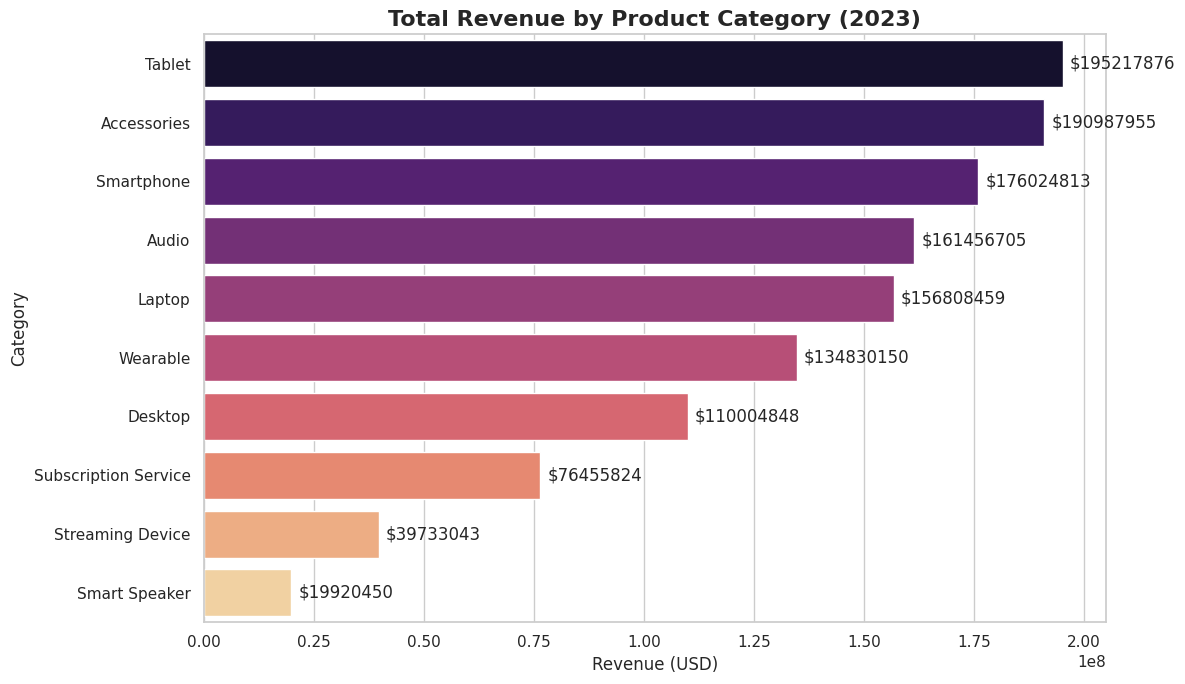

In [19]:
# 1.1 Revenue per Category
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x=category_perf['total_revenue'],
    y=category_perf.index,
    palette='magma'
)

plt.title('Total Revenue by Product Category (2023)', fontsize=16, fontweight='bold')
plt.xlabel('Revenue (USD)', fontsize=12)
plt.ylabel('Category', fontsize=12)

# Add data labels for clarity
for i in ax.containers:
    ax.bar_label(i, padding=5, fmt='$%.0f')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3771721839.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-3771721839.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-3771721839.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-3771721839.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-3771721839.py:16: Fut

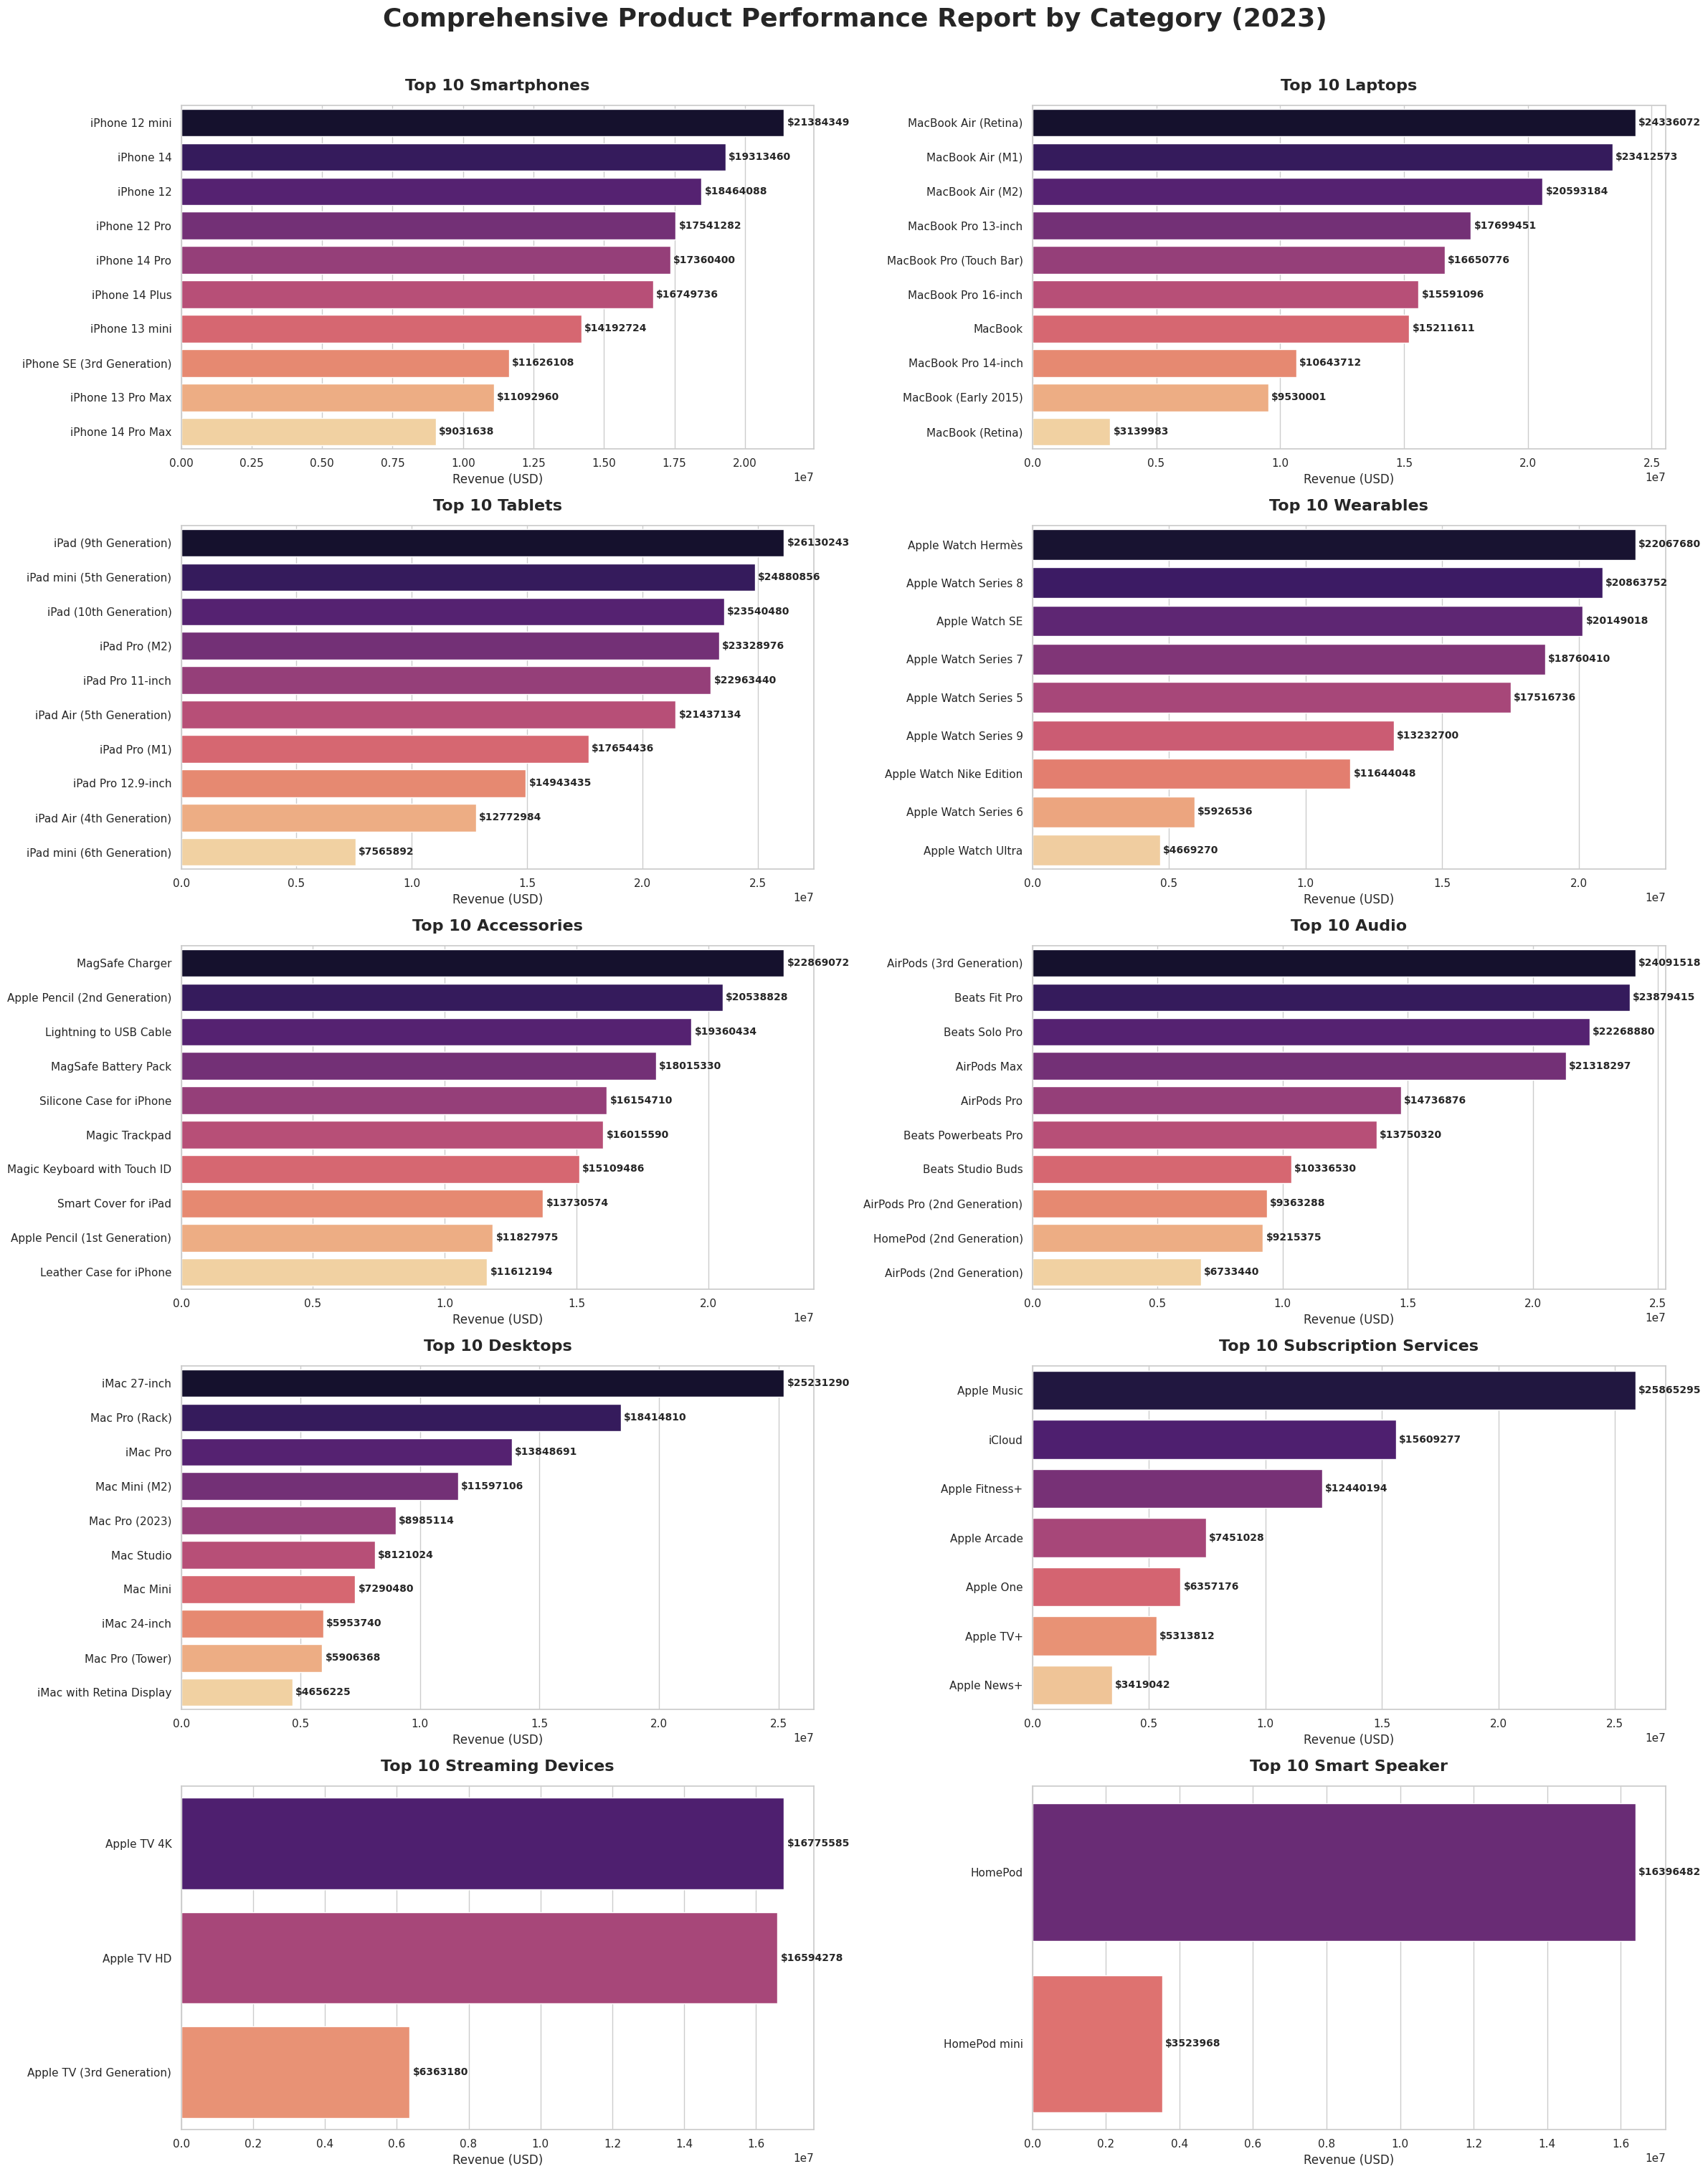

In [20]:
# List of dataframes we created earlier
performance_list = [
    (phone_perf, 'Smartphones'), (laptop_perf, 'Laptops'),
    (tablet_perf, 'Tablets'), (wear_perf, 'Wearables'),
    (accs_perf, 'Accessories'), (audio_perf, 'Audio'),
    (desktop_perf, 'Desktops'), (subs_perf, 'Subscription Services'),
    (streaming_perf, 'Streaming Devices'),(speaker_perf, 'Smart Speaker')
]

# Create a 5x2 Grid for the 10 categories
fig, axes = plt.subplots(5, 2, figsize=(24, 30)) # Increased height for better readability
axes = axes.flatten()

for i, (data, title) in enumerate(performance_list):
    # Plotting on the specific subplot axis
    ax = sns.barplot(
        x='total_revenue',
        y=data.index,
        data=data,
        ax=axes[i],
        palette='magma'
    )

    # Customizing each subplot
    axes[i].set_title(f'Top 10 {title}', fontsize=16, fontweight='bold', pad=15)
    axes[i].set_xlabel('Revenue (USD)', fontsize=12)
    axes[i].set_ylabel('')

    # ADDING DATA LABELS (Inside the loop so it applies to every chart)
    for container in axes[i].containers:
        axes[i].bar_label(
            container,
            padding=3,
            fmt='$%.0f',
            fontsize=10,
            fontweight='bold'
        )

# Main Title for the entire report page
plt.suptitle('Comprehensive Product Performance Report by Category (2023)',
             fontsize=26, fontweight='bold', y=1.01)

plt.tight_layout()
plt.show()

### Geography & Store Performance

In [21]:
import plotly.express as px

# Re-calculate country_perf to ensure it holds country-level data
country_perf_actual = df_master.groupby('Country').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False)

# 2.1 Country-Level Visualization (Interactive Treemap)
fig_country = px.treemap(
    country_perf_actual.reset_index(),
    path=['Country'],
    values='total_revenue',
    title='Revenue Contribution by Country (2023)',
    color='total_revenue',
    color_continuous_scale='RdBu'
)
fig_country.show()

# Re-calculate city_perf to ensure it holds city-level data
city_perf_actual = df_master.groupby('City').agg(
    total_transactions=('sale_id', 'count'),
    total_items_sold=('quantity', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_values('total_revenue', ascending=False)


/tmp/ipython-input-2048920478.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




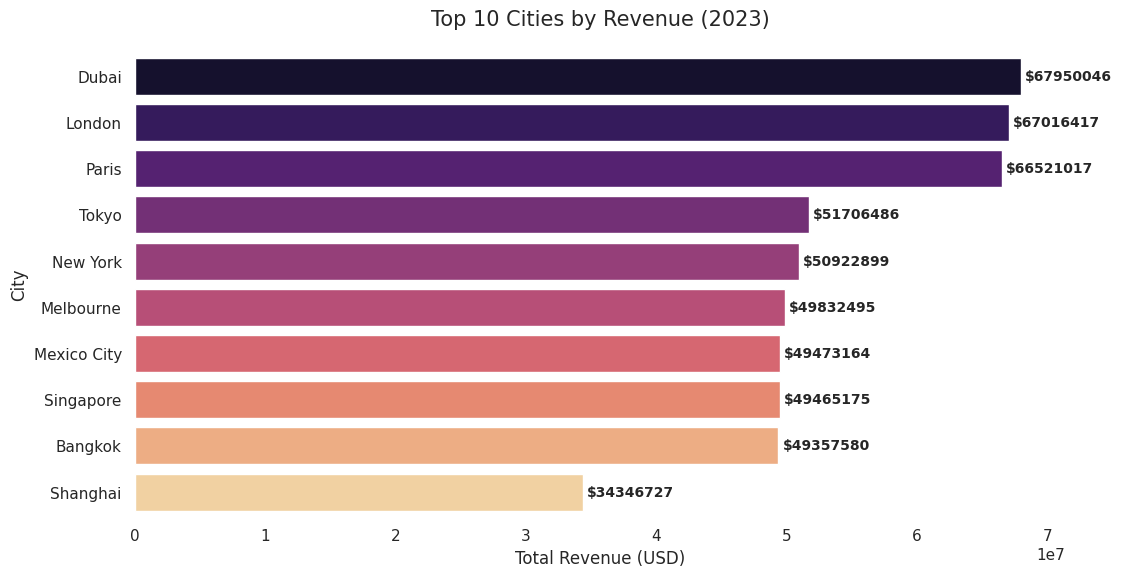

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (12, 8)

# 2.2 Top Cities by Revenue
top_cities = city_perf_actual.head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='total_revenue',
    y=top_cities.index,
    data=top_cities,
    palette='magma'
)

# ADDING DATA LABELS
# We use ax.bar_label to put the revenue amount at the end of each bar
for i in ax.containers:
    ax.bar_label(i, padding=3, fmt='$%.0f', fontsize=10, fontweight='bold')

plt.title('Top 10 Cities by Revenue (2023)', fontsize=15, pad=20)
plt.xlabel('Total Revenue (USD)')
plt.ylabel('City')
sns.despine(left=True, bottom=True)
plt.show()

### Warranty & Quality

/tmp/ipython-input-4113493999.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-4113493999.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




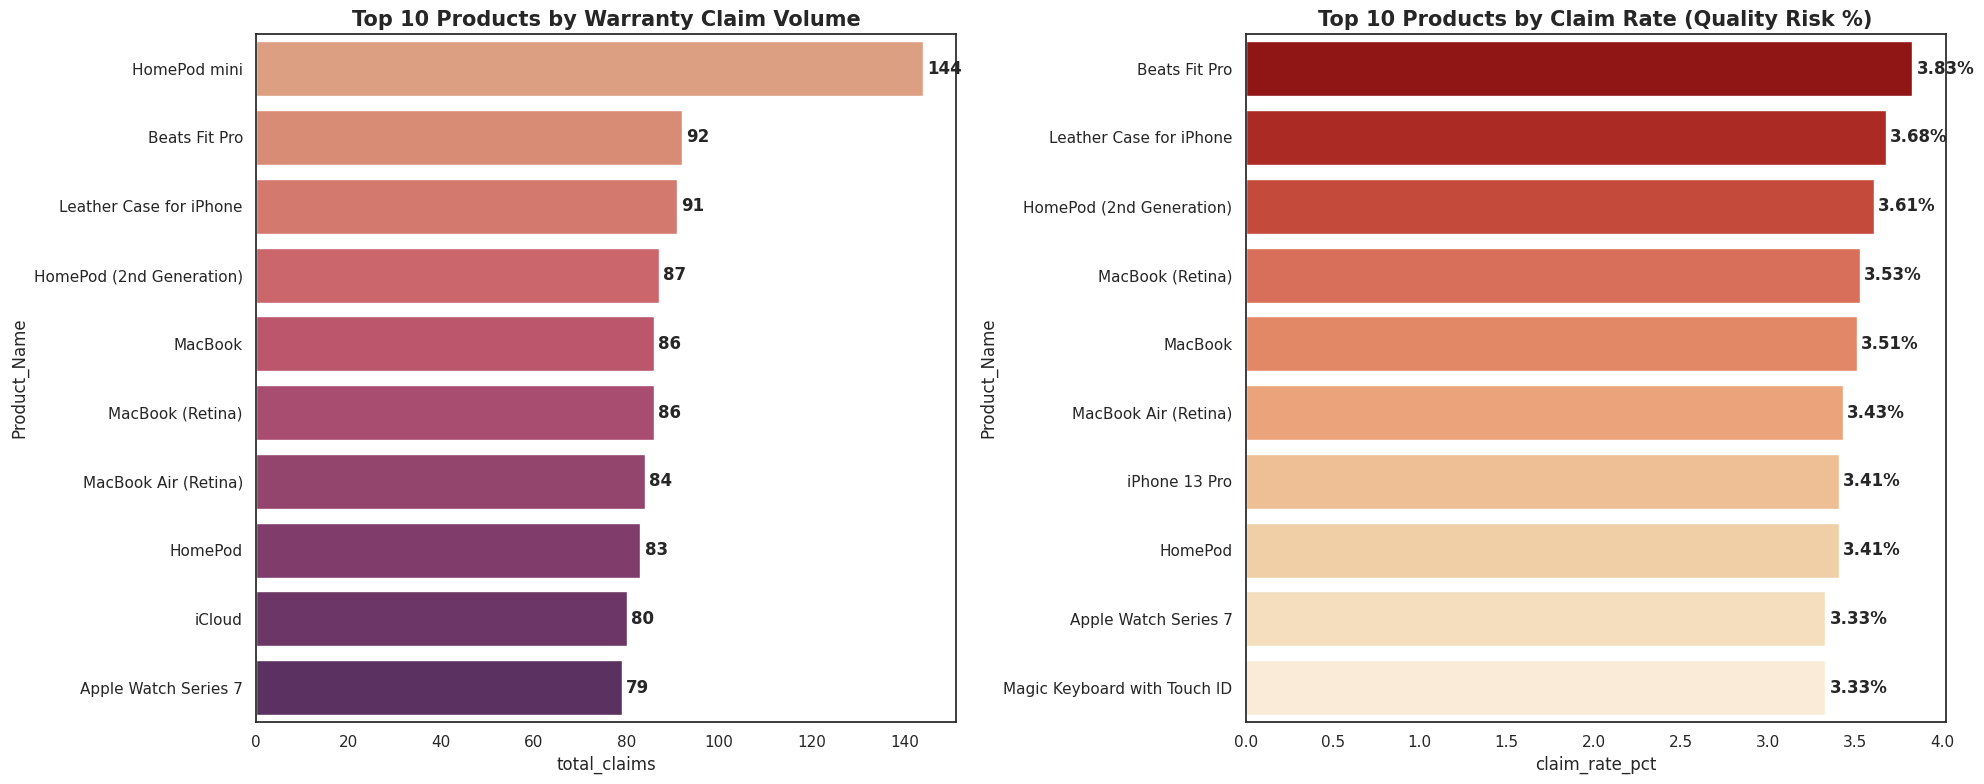

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 3.1 Top 10 Products by Claim Volume
top_vol = warranty_claim_vol.head(10)
sns.barplot(x='total_claims', y=top_vol.index, data=top_vol, ax=axes[0], palette='flare')
axes[0].set_title('Top 10 Products by Warranty Claim Volume', fontsize=15, fontweight='bold')
for i in axes[0].containers:
    axes[0].bar_label(i, padding=3, fmt='%d', fontweight='bold')

# 3.4 Top 10 Products by Claim Rate (%)
top_rate = summary.sort_values('claim_rate_pct', ascending=False).head(10)
sns.barplot(x='claim_rate_pct', y=top_rate.index, data=top_rate, ax=axes[1], palette='OrRd_r')
axes[1].set_title('Top 10 Products by Claim Rate (Quality Risk %)', fontsize=15, fontweight='bold')
for i in axes[1].containers:
    axes[1].bar_label(i, padding=3, fmt='%.2f%%', fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-614675719.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




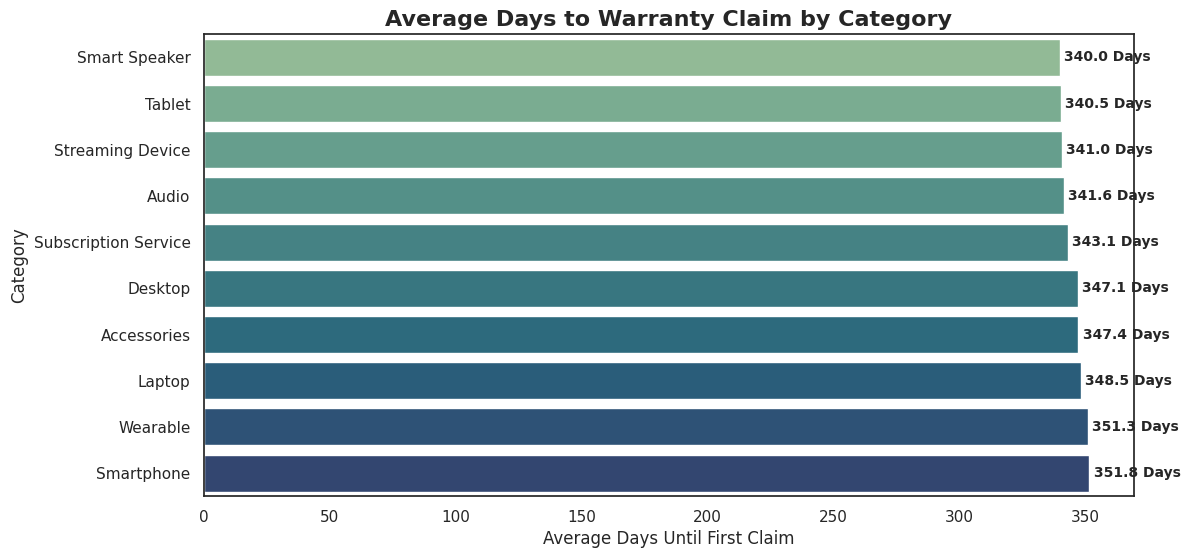

In [24]:
# 3.2 Average Days to Claim (Reliability Metric)
plt.figure(figsize=(12, 6))
# Sort by avg_days_to_claim ascending
ax = sns.barplot(x='avg_days_to_claim', y=reliability_analysis.index,
                 data=reliability_analysis, palette='crest')

# Adding data labels
for i in ax.containers:
    ax.bar_label(i, padding=3, fmt='%.1f Days', fontsize=10, fontweight='bold')

plt.title('Average Days to Warranty Claim by Category', fontsize=16, fontweight='bold')
plt.xlabel('Average Days Until First Claim')
plt.ylabel('Category')
plt.show()

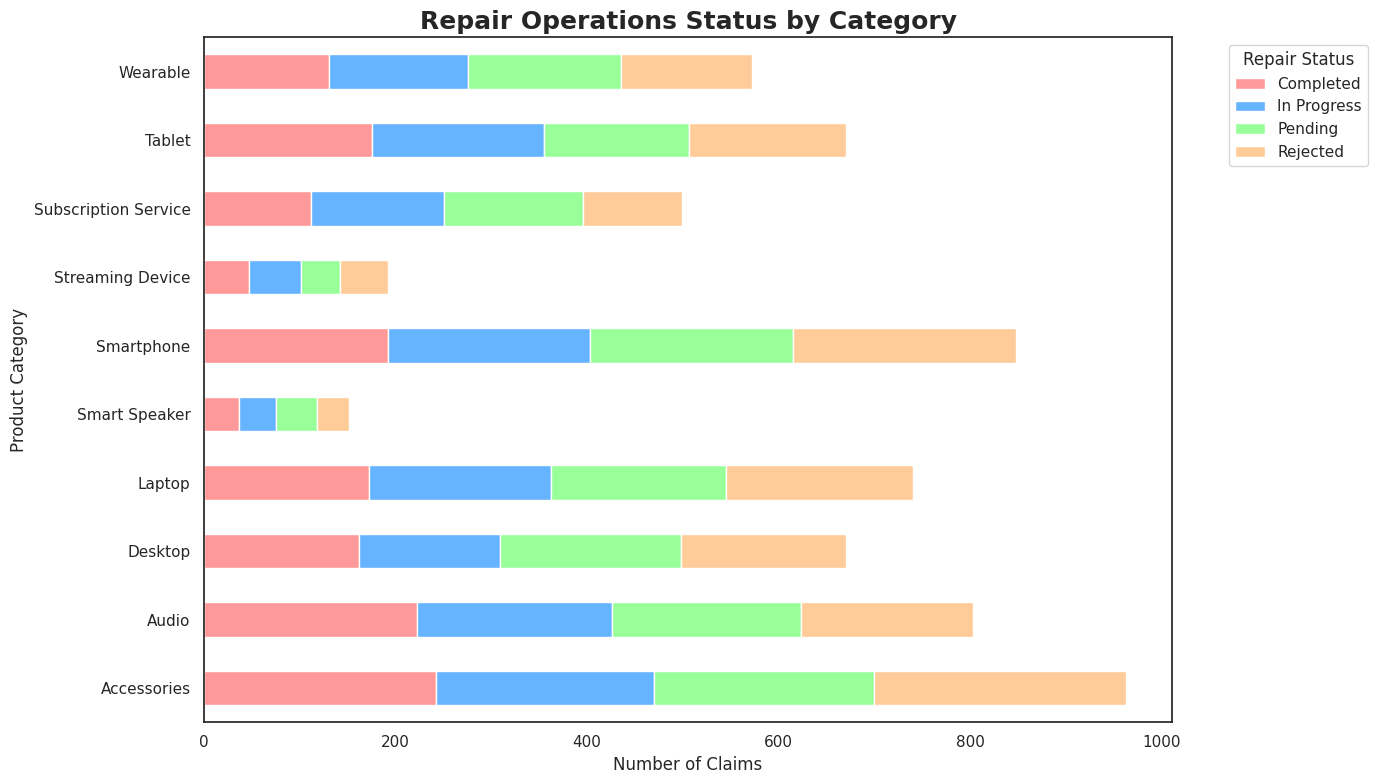

In [25]:
# 3.3 Repair Status Pivot Table
# Prepare data for stacked bar (exclude total and percentage columns)
status_plot_data = repair_pivot.drop(columns=['total_claims', 'percentage_of_total'])

status_plot_data.plot(kind='barh', stacked=True, figsize=(14, 8),
                      color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

plt.title('Repair Operations Status by Category', fontsize=18, fontweight='bold')
plt.xlabel('Number of Claims')
plt.ylabel('Product Category')
plt.legend(title='Repair Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Summary

This data analysis provides a comprehensive overview of Apple Retail performance for the fiscal year 2023, spanning revenue, geographic contribution, and product quality metrics.

#### 1. Revenue & Product Performance
The high-level category analysis shows that Tablets are the primary revenue drivers, followed closely by Accessories.

* Top Categories: Tablet leads with approximately $195M, while Accessories follow at $191M.

* Smartphone Leaders: The iPhone 12 mini and iPhone 14 generated the most revenue in this category.

* Computing Performance: The MacBook Air (Retina) and iMac 27-inch are the top performers in the Laptop and Desktop categories, respectively.

* Emerging Segments: Subscription services, led by Apple Music, prove to be a significant recurring revenue stream.

#### Geographic Distribution
Revenue is heavily concentrated in major global markets, with the United States acting as the primary hub.

* Primary Market: The United States contributed the largest share with over $254M in revenue.

* Key Global Markets: China ($117.6M), Australia ($117.2M), and Japan ($102.6M) are the other top-tier contributors.

* European Presence: The United Kingdom ($67M) and France ($66.5M) lead the European market.

#### Warranty & Quality Assurance
While some products drive high sales, they also present different levels of quality risk based on claim volumes and rates.

* Claim Volume: The HomePod mini had the highest absolute number of service requests (144 claims).

* Quality Risk (Claim Rate): The Beats Fit Pro presents the highest quality risk with a 3.83% claim rate, followed by the Leather Case for iPhone at 3.68%.

* Reliability (Time to Claim): Most categories show a first claim appearing after roughly 340 to 352 days, suggesting hardware issues often arise near the end of the standard one-year warranty period.

* Repair Efficiency: Accessories and Audio categories have the highest workload for service centers. A significant portion of these claims remains "Pending" or "In Progress," highlighting potential service bottlenecks.